In [67]:
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt

In [3]:
# Environment

In [5]:
OBS_SIZE = (3,3)

In [406]:

def rec(depth):
    """ Creates all possible states
    """
    numbers = [-1,0,1]
    if depth == 0:
        return []
    elif depth == 1:
        return [[x] for x in numbers]
    else:
        return [[x]+lower  for x in numbers for lower in rec(depth-1)]
            

states = [tuple(perm) for perm in rec(9)]

# print(states)
Q = [{},{}]
for s in states:
    Q[0][s] = [np.random.uniform(-5,0) for i in range(9)]
    Q[1][s] = [np.random.uniform(-5,0) for i in range(9)]
    
DISCOUNT = 0.9
LEARNING_RATE = 0.1
EPS_DECAY = 0.9999
EPISODES = 100000
WIN = 100
LOSE = -100
MOVE = -1


class Game():

    def __init__(self):
        self.T = np.zeros((3,3))
        self.EPSILON = 0.5
    
    def state_as_tuple(self):
        return tuple(self.T.reshape(9))
         
    
    def move(self,x,y,v):
        assert self.T[x,y] == 0, "Trying to move on non-empty slot."
        self.T[x,y] = v
        return self.T
        
    def action_is_legal(self,action):
        return self.state_as_tuple()[action] == 0
        
        
    def move_player(self,player):
        if player == 0:
            sign = -1
        else:
            sign = 1
        
        obs = self.state_as_tuple()
        
        if np.random.random()> EPSILON:
            action = np.argmax(Q[player][obs]) 
        else:
            action = np.random.randint(9)
        
        while not self.action_is_legal(action):
            if np.random.random()>EPSILON:
                action = np.argmax(Q[player][obs]) 
            else:
                action = np.random.randint(9)
        
        self.move(action//3,action%3,sign)
        
        
        ce = self.check_end()
        if ce == 0:
            reward = MOVE
        elif ce == sign:
            reward = WIN
        else:
            reward = LOSE
        
        new_obs = self.state_as_tuple()
        max_future_q = np.argmax(Q[player][new_obs])
        current_q = Q[player][obs][action]
        
        new_q = reward
        if reward == -1:
            new_q = (1-LEARNING_RATE)*current_q + LEARNING_RATE*(reward+DISCOUNT*max_future_q)
        elif reward == LOSE:
            new_q = LOSE
        else:
            new_q = WIN
        Q[player][obs][action] = new_q
        
        self.EPSILON *=EPS_DECAY
        
        return self.T
        
        
    def move_bot(self):
        xs,ys = np.where(self.T == 0)
        i = np.random.randint(len(xs))
        
        self.move( xs[i],ys[i],-1 )
        return self.T
        
    
    def check_end(self):
        for rows in self.T:
            if rows.sum() == -3: return -1
            if rows.sum() == 3: return 1
        for cols in self.T.T:
            if cols.sum() == -3: return -1
            if cols.sum() == 3: return 1
        if np.diag(self.T).sum() == -3: return -1
        if np.diag(self.T).sum() == 3: return 1
        if np.diag(np.rot90(self.T)).sum() == -3: return -1
        if np.diag(np.rot90(self.T)).sum() == 3: return 1
        
        return 0
    
    def can_move(self):
        return False if np.all(self.T.reshape(9) != 0) or self.check_end() else True
    
    
    def run_games(self):
        stats = []
        N = EPISODES
        for i in range(N):
            
            if (i+1)%(N/10)==0: print(f"{((i+1)*10)//(N/10)}% Done")
            self.T = np.zeros((3,3))
            pt = bool(np.random.randint(2))
            pt = True
            while self.can_move():
                # print("Turn")
                if pt:
                    self.move_player(1)
                    self.EPSILON *= EPS_DECAY
                else:
                    self.move_bot()
                    # self.move_player(0)
                pt = not pt
            stats.append(self.check_end())
        return stats
        
        

In [407]:
g = Game()
results = np.asarray(g.run_games())

10.0% Done
20.0% Done
30.0% Done
40.0% Done
50.0% Done
60.0% Done
70.0% Done
80.0% Done
90.0% Done
100.0% Done


Won 0.80145 | Lost 0.12515
[-3.9409220735004196, -1.0680307368846327, -2.049943321920601, -3.852057812392498, -1.9642564361595123, -2.3751458077572822, -3.5572448334882885, -2.559478609338181, -4.1725016758267985]


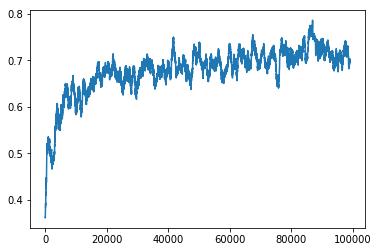

In [410]:
window_size = 1000

ys = []
for i in range(len(results) -(window_size-1)):
    ys.append(np.asarray(results[i:i+window_size]).mean())
    

plt.plot(range(len(ys)),ys)
win_rat = np.sum(results > 0) / results.shape[0]
lose_rat = np.sum(results < 0) / results.shape[0]

print(f"Won {win_rat} | Lost {lose_rat}")